In [1]:
import xarray as xr
import xroms
import xgcm
from xhistogram.xarray import histogram
# from xrspatial.convolution import convolution_2d

import matplotlib.pyplot as plt
import cmocean.cm as cmo
import numpy as np
import cf_xarray
import ffmpeg
import uxarray as ux
from glob import glob
import os
import time

from scipy import signal

import warnings
warnings.filterwarnings('ignore')

ERROR 1: PROJ: proj_create_from_database: Open of /global/u2/k/kehinson/mambaforge/envs/mamba_env1/share/proj failed


In [2]:
run /global/homes/k/kehinson/Notebooks/bichan_utils_KH.py

In [3]:
from dask_jobqueue import PBSCluster
from dask.distributed import Client, LocalCluster

In [3]:
# cluster = LocalCluster()
# client = Client(cluster)

# cluster.scheduler

In [4]:
# cluster = PBSCluster(cores=256, memory='200GB')
# client = Client(cluster)

In [3]:
import dask
from dask.distributed import Client, LocalCluster
# cluster = LocalCluster()
# client = Client(cluster)
client = Client()
# # client = Client(n_workers=os.cpu_count()-2, threads_per_worker=1)
client

<Client: 'tcp://127.0.0.1:35071' processes=16 threads=256, memory=476.56 GiB>

In [10]:
cycles = 4 # how many sine cycles
resolution = 200 # how many datapoints to generate

length = np.pi * 2 * cycles
my_wave = np.sin(np.arange(0, length, length / resolution))

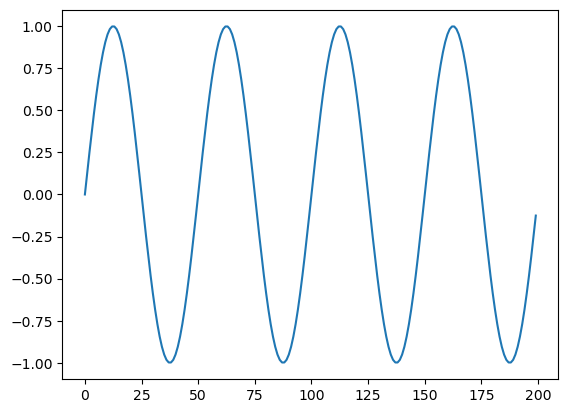

In [11]:
plt.plot(my_wave)

In [92]:
# plt.psd(my_wave)

In [93]:
# signal.periodogram(my_wave,12)

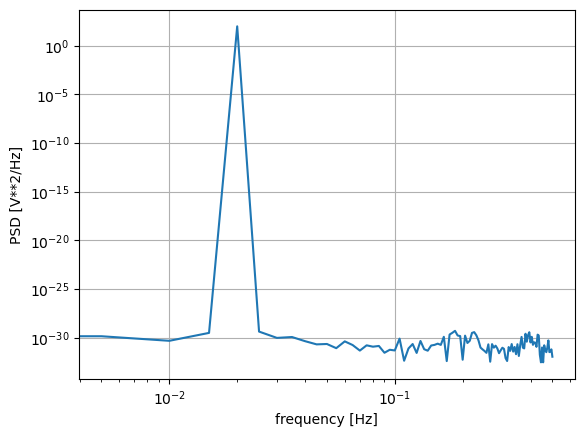

In [12]:
f, Pxx_den = signal.periodogram(my_wave)

plt.loglog(f, Pxx_den)
# plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.grid()
plt.show()

In [13]:
f[0:5]

array([0.   , 0.005, 0.01 , 0.015, 0.02 ])

In [14]:
Pxx_den[0:5]

array([1.26117929e-31, 1.40434223e-30, 4.77533580e-31, 3.09997734e-30,
       1.00000000e+02])

In [15]:
np.max(Pxx_den[0:5])

100.0

In [48]:
Pxx_den

array([8.03853066e-33, 9.54144401e-30, 3.00000000e+02, 2.74583138e-29,
       7.47778288e-30, 4.10687204e-30, 2.78966059e-30, 1.84174510e-30,
       1.64922772e-30, 1.02930453e-30, 7.90987633e-31, 6.60994616e-31,
       1.33117916e-30, 9.19377371e-31, 2.72968189e-31, 4.09746942e-31,
       3.96529914e-31, 3.22340377e-31, 3.47561933e-31, 1.26820176e-31,
       1.17178754e-31, 2.03555384e-31, 2.70511490e-31, 2.93602262e-31,
       1.63002485e-31, 1.54740952e-31, 6.43301759e-32, 4.34902892e-34,
       5.17173512e-32, 6.27988077e-32, 1.59455422e-31, 7.19146259e-32,
       1.88300961e-31, 5.83860433e-32, 1.59895535e-31, 7.52854465e-32,
       1.38490427e-32, 6.78090991e-33, 2.05460352e-31, 3.11860110e-31,
       2.95818524e-31, 5.89780674e-31, 2.91574938e-31, 2.85719363e-31,
       8.20391516e-32, 6.45380274e-31, 1.92136409e-32, 1.50853327e-31,
       7.98996649e-32, 1.49312174e-32, 3.30562550e-32, 8.49674046e-32,
       1.44634485e-31, 8.25224410e-32, 5.69232983e-32, 1.80577649e-32,
      

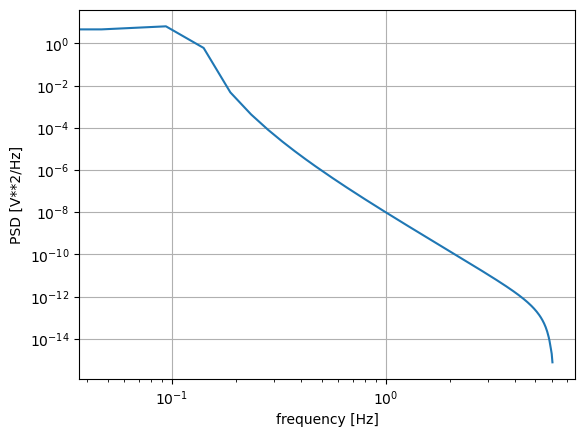

In [104]:
f, Pxx_den = signal.welch(my_wave, 12)
plt.loglog(f, Pxx_den)
# f2, Pxx_den2 = signal.welch(ke_roms[-1]/rho0, 12)
# plt.loglog(f2, Pxx_den2)
# plt.ylim([0.5e-3, 1])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
# plt.show()
plt.grid()

In [105]:
f[0:10]

array([0.      , 0.046875, 0.09375 , 0.140625, 0.1875  , 0.234375,
       0.28125 , 0.328125, 0.375   , 0.421875])

In [106]:
Pxx_den[0:10]

array([4.11089070e-01, 4.56057125e+00, 6.36989429e+00, 6.02553518e-01,
       4.73649993e-03, 4.27415466e-04, 8.02864424e-05, 2.21319494e-05,
       7.75436355e-06, 3.20345345e-06])

In [107]:
np.max(Pxx_den)

6.369894293469902

## Stitch together multiple 100 m MPAS-O outputs into a single dataset

In [10]:
## Combine 100 m MPAS-O outputs in a single dataset

m100files = [
        '/global/cfs/cdirs/m4304/kehinson/channel_runs/mpaso_channel/100m_halfvisc/output.nc',
        '/global/cfs/cdirs/m4304/kehinson/channel_runs/mpaso_channel/100m_halfvisc/output_2.nc',
        '/global/cfs/cdirs/m4304/kehinson/channel_runs/mpaso_channel/100m_halfvisc/output_3.nc'    
]

m100init = '/global/cfs/cdirs/m4304/kehinson/channel_runs/mpaso_channel/100m_halfvisc/channel_init.nc'
#         '/global/cfs/cdirs/m4304/kehinson/channel_runs/mpaso_channel/100m_qdrag/rst.0001-01-21_00.00.00.nc',
#         '/global/cfs/cdirs/m4304/kehinson/channel_runs/mpaso_channel/100m_qdrag/rst.0001-02-15_00.00.00.nc'
# ]

mds = []
mdsg = []


for mfile in m100files:
    ds_mpas = xr.open_dataset(mfile, chunks={'Time': 1})
    dsg = xr.open_dataset(m100init)
    mds.append(ds_mpas)
    mdsg.append(dsg)



In [11]:
m100files

['/global/cfs/cdirs/m4304/kehinson/channel_runs/mpaso_channel/100m_halfvisc/output.nc',
 '/global/cfs/cdirs/m4304/kehinson/channel_runs/mpaso_channel/100m_halfvisc/output_2.nc',
 '/global/cfs/cdirs/m4304/kehinson/channel_runs/mpaso_channel/100m_halfvisc/output_3.nc']

In [6]:
mds[0].xtime.values[-24]

b'0001-01-20_22:00:00'

In [7]:
mds[1].xtime.values[0]

b'0001-01-21_00:00:00'

In [8]:
mds[1].xtime.values[-3]

b'0001-02-14_22:00:00'

In [9]:
mds[2].xtime.values[0]

b'0001-02-15_00:00:00'

In [10]:
mds[2].xtime.values[-150]

b'0001-03-02_00:00:00'

In [11]:
ds0 = mds[0]

In [12]:
ds0 = mds[0].isel(Time=slice(0,-24))
ds1 = mds[1].isel(Time=slice(0,-3))
ds2 = mds[2].isel(Time=slice(0,-150))

In [29]:
print(mds[0].xtime[0].values)
print(mds[0].xtime[-1].values)
print('\n')
print(mds[1].xtime[0].values)
print(mds[1].xtime[-1].values)
print('\n')
print(mds[2].xtime[0].values)
print(mds[2].xtime[-1].values)

b'0001-01-01_00:00:00'
b'0001-01-22_20:00:00'


b'0001-01-21_00:00:00'
b'0001-02-15_02:00:00'


b'0001-02-15_00:00:00'
b'0001-03-14_10:00:00'


In [31]:
mds[0].xtime[-24].values

array(b'0001-01-20_22:00:00', dtype='|S64')

In [28]:
mds[1].xtime[0].values

array(b'0001-01-21_00:00:00', dtype='|S64')

In [33]:
os.chdir('/global/cfs/cdirs/m4304/kehinson/channel_runs/mpaso_channel/100m_halfvisc')

In [34]:
pwd

'/global/cfs/cdirs/m4304/kehinson/channel_runs/mpaso_channel/100m_halfvisc'

In [35]:
mds100zarr = xr.concat([ds0, ds1], "Time", combine_attrs="drop_conflicts")

In [38]:
# save abbreviated version of this to zarr format
zfile = '/global/cfs/cdirs/m4304/kehinson/channel_runs/mpaso_channel/100m_halfvisc/output.zarr'

In [40]:
mds100zarr.to_zarr(zfile)

In [ ]:
mds100 = xr.concat([ds0, ds1, ds2], "Time", combine_attrs="drop_conflicts")

In [22]:
print(mds[0].Time[-1].values)

262


In [20]:
print(ds1.Time[0].values)

0


In [23]:
print(mds[0].Time.shape)
print(mds[1].Time.shape)
print(mds[2].Time.shape)

(263,)
(302,)
(330,)


In [14]:
ds1.Time.shape

(299,)

In [15]:
ds2.Time.shape

(180,)

In [13]:
mds100 = xr.concat([ds0, ds1, ds2], "Time", combine_attrs="drop_conflicts")

In [14]:
mds100.xtime[-1].values

array(b'0001-03-01_22:00:00', dtype='|S64')

In [15]:
mds100

<xarray.Dataset>
Dimensions:                (Time: 718, nEdges: 10388000, nVertLevels: 30,
                            nCells: 3462000, nVertices: 6926000,
                            nVertLevelsP1: 31)
Dimensions without coordinates: Time, nEdges, nVertLevels, nCells, nVertices,
                                nVertLevelsP1
Data variables:
    xtime                  (Time) |S64 dask.array<chunksize=(1,), meta=np.ndarray>
    normalVelocity         (Time, nEdges, nVertLevels) float32 dask.array<chunksize=(1, 10388000, 30), meta=np.ndarray>
    layerThickness         (Time, nCells, nVertLevels) float32 dask.array<chunksize=(1, 3462000, 30), meta=np.ndarray>
    layerThicknessVertex   (Time, nVertices, nVertLevels) float32 dask.array<chunksize=(1, 6926000, 30), meta=np.ndarray>
    divergence             (Time, nCells, nVertLevels) float32 dask.array<chunksize=(1, 3462000, 30), meta=np.ndarray>
    kineticEnergyCell      (Time, nCells, nVertLevels) float32 dask.array<chunksize=(1, 3462000, 30), meta=np.ndarray>
    relativeVorticityCell  (Time, nCells, nVertLevels) float32 dask.array<chunksize=(1, 3462000, 30), meta=np.ndarray>
    vertVelocityTop        (Time, nCells, nVertLevelsP1) float32 dask.array<chunksize=(1, 3462000, 31), meta=np.ndarray>
    temperature            (Time, nCells, nVertLevels) float32 dask.array<chunksize=(1, 3462000, 30), meta=np.ndarray>
    salinity               (Time, nCells, nVertLevels) float32 dask.array<chunksize=(1, 3462000, 30), meta=np.ndarray>
Attributes: (12/1266)
    model_name:                                                      mpas
    core_name:                                                       ocean
    source:                                                          MPAS
    Conventions:                                                     MPAS
    git_version:                                                     v2.0.0-1...
    on_a_sphere:                                                     NO
    ...                                                              ...
    config_rx1_vert_smooth_weight:                                   1.0
    config_rx1_slope_weight:                                         0.1
    config_rx1_zstar_weight:                                         1.0
    config_rx1_horiz_smooth_open_ocean_cells:                        20
    config_rx1_min_levels:                                           3
    config_rx1_min_layer_thickness:                                  1.0

In [16]:
ympas = mdsg[0].yCell.values
# find cells with values greater than 50E3 and less than 250E3
ympas.shape
type(ympas)

numpy.ndarray

In [17]:
ympas

array([1.73205081e+02, 1.73205081e+02, 1.73205081e+02, ...,
       2.99904597e+05, 2.99904597e+05, 2.99904597e+05])

In [18]:
idx100 = np.where(np.logical_and(ympas>50000, ympas<250000))

In [19]:
idx100[0][-5::]

array([2884995, 2884996, 2884997, 2884998, 2884999])

In [38]:
ympas = mdsg[0].yCell.values
idx100 = np.where(np.logical_and(ympas>50000, ympas<250000))
mpas100_ke = mds100.kineticEnergyCell.isel(
                nVertLevels=0, nCells=slice(idx100[0][0], idx100[0][-1])).mean(dim='nCells').compute()

In [38]:
mpas100_ke = mds100.kineticEnergyCell.isel(
                nVertLevels=0, nCells=slice(idx100[0][0], idx100[0][-1])).mean(dim='nCells').compute()

In [60]:
# mpas100_ke = mds100.kineticEnergyCell.isel(nVertLevels=0).mean(dim='nCells').compute()

In [41]:
np.save('/global/cfs/cdirs/m4304/kehinson/channel_runs/mpaso_channel/100m_halfvisc/ke_100m.npy', mpas100_ke)

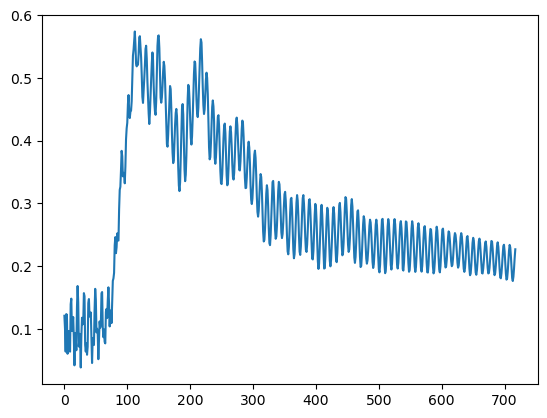

In [39]:
plt.plot(mpas100_ke)

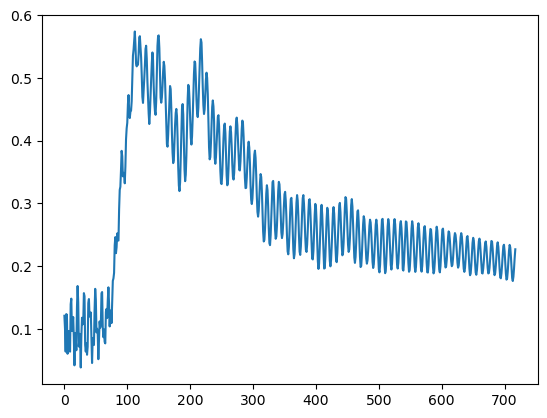

In [24]:
plt.plot(mpas100_ke)

### Try using uxarray for MPAS mesh

In [75]:
# root_dir = '/pscratch/sd/k/kehinson/seahorce/mpaso_channel/bichan_GLS/200m_halfvisc/channel_init.nc'

# primal_mesh = ux.open_grid(root_dir, use_dual=False)
# dual_mesh = ux.open_grid(root_dir, use_dual=True)


In [10]:
# mname = '/pscratch/sd/k/kehinson/seahorce/mpaso_channel/bichan_GLS/10km_halfvisc/output.nc'

# mxr = xr.open_dataset(mname)
# mds200 = ux.UxDataset(mxr)

In [ ]:
# rootdir = '/global/cfs/cdirs/m4304/mpaso_channel/{case}/'.format(case=case)
# ds_mpas = xarray.open_dataset(rootdir + 'output.nc', chunks={'Time': 1})
# dsg = xarray.open_dataset(rootdir + 'channel_init.nc')

# ds_mpas['normalizedRelativeVorticity'] = ds_mpas.relativeVorticityCell / dsg.fCell

# verts = np.dstack((dsg.xVertex.values[dsg.verticesOnCell-1],
#                    dsg.yVertex.values[dsg.verticesOnCell-1]))
# nverts = np.sum(dsg.verticesOnCell != 0, axis=1).values
# verts = [vert[:n] for vert, n in zip(verts, nverts)]
# idx = [(np.abs(vert[:, 0].ptp()) < 50000) for vert in verts]
# verts = np.array(verts)[idx]

# norm = plt.matplotlib.colors.Normalize(-3, 3)

## Load MPAS-O data

In [6]:
mroots = [
         '/pscratch/sd/k/kehinson/seahorce/mpaso_channel/bichan_GLS/10km_halfvisc/',
         '/pscratch/sd/k/kehinson/seahorce/mpaso_channel/bichan_GLS/5km_halfvisc/',
         '/pscratch/sd/k/kehinson/seahorce/mpaso_channel/bichan_GLS/2km_halfvisc/',
         '/pscratch/sd/k/kehinson/seahorce/mpaso_channel/bichan_GLS/1km_halfvisc/',
         '/pscratch/sd/k/kehinson/seahorce/mpaso_channel/bichan_GLS/500m_halfvisc/',    
         '/pscratch/sd/k/kehinson/seahorce/mpaso_channel/bichan_GLS/200m_halfvisc/'    
]

In [7]:
mds = []
mdsg = []
mverts = []
midx = []
mnorm = []
for rootdir in mroots:
    ds_mpas = xr.open_dataset(rootdir + 'output.nc', chunks={'Time': 1})
    dsg = xr.open_dataset(rootdir + 'channel_init.nc')
    ds_mpas['normalizedRelativeVorticity'] = ds_mpas.relativeVorticityCell / dsg.fCell
    ds_mpas['normalizedDivergence'] = ds_mpas.divergence / dsg.fCell
    mds.append(ds_mpas)
    mdsg.append(dsg)

    verts = np.dstack((dsg.xVertex.values[dsg.verticesOnCell-1],
                       dsg.yVertex.values[dsg.verticesOnCell-1]))
    nverts = np.sum(dsg.verticesOnCell != 0, axis=1).values
    verts = [vert[:n] for vert, n in zip(verts, nverts)]
    idx = [(np.abs(vert[:, 0].ptp()) < 50000) for vert in verts]
    midx.append(idx)
    verts = np.array(verts)[idx]
    mverts.append(verts)

    norm = plt.matplotlib.colors.Normalize(-3, 3)
    mnorm.append(norm)

In [8]:
m_lgd = ['10 km', '5 km', '2 km', '1 km', '500 m', '200 m']

### Calculate surface KE for MPAS-O

In [12]:
# Remove effects of walls to better match ROMS

mkes = []
for axi in range(len(mds)):
    # mpas_ke = mds[axi].kineticEnergyCell.isel(nVertLevels=0).mean(dim='nCells').compute()
    # mkes.append(mpas_ke)
    t1 = time.time()
    ympas = mdsg[axi].yCell.values
    idx = np.where(np.logical_and(ympas>50000, ympas<250000))
    mpas_ke = mds[axi].kineticEnergyCell.isel(
                nVertLevels=0, nCells=slice(idx[0][0], idx[0][-1])).mean(dim='nCells').compute()
    mkes.append(mpas_ke)
    print(time.time()-t1)

4.9049859046936035
1.3587124347686768
3.437368869781494
8.798707246780396
24.701822757720947
120.88741755485535


In [13]:
len(mkes)

6

In [4]:
rainbow_cmap = np.asarray([[165,0,38],
                         [215,48,39],
                         [253,174,97],
                         [0,0,0],
                         [171,217,233],
                         [116,173,209],
                         [49,54,149]]) / 255

rainbow_cmap

array([[0.64705882, 0.        , 0.14901961],
       [0.84313725, 0.18823529, 0.15294118],
       [0.99215686, 0.68235294, 0.38039216],
       [0.        , 0.        , 0.        ],
       [0.67058824, 0.85098039, 0.91372549],
       [0.45490196, 0.67843137, 0.81960784],
       [0.19215686, 0.21176471, 0.58431373]])

Text(0.5, 1.0, 'MPAS-O')

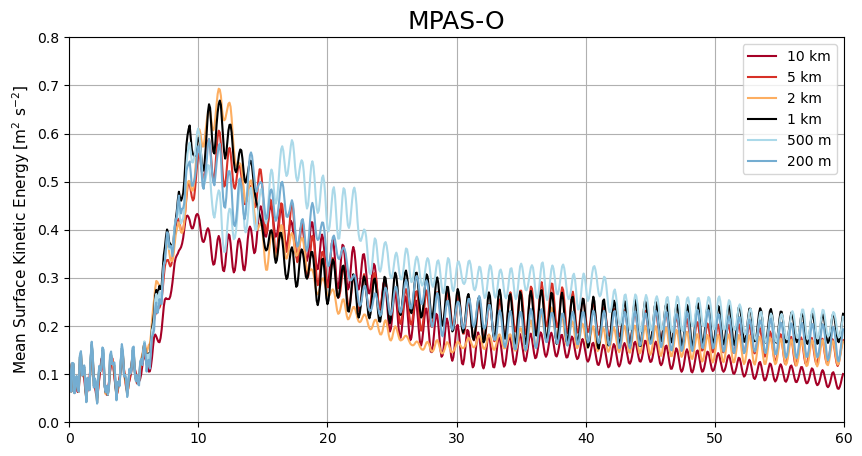

In [15]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

ndays = 60
tsteps = ndays * 12

t = np.linspace(0, ndays-2/24, int(ndays/(2/24)))

for iplot in range(len(mkes)):
    # if iplot==5:
    mpas_ke = mkes[iplot]
    # elif iplot!=5:
    #     mpas_ke = mkes[iplot] / 1025
    ax.plot(t[0:len(mpas_ke)], mpas_ke[:tsteps], label=m_lgd[iplot],
           color=rainbow_cmap[iplot,:])

ax.set_ylim(0, 0.8)
ax.set_xlim(0, 60)
ax.grid(True)

ax.set_ylabel('Mean Surface Kinetic Energy [m$^{2}$ s$^{-2}$]', fontsize=11)
ax.legend(loc='upper right')
ax.set_title('MPAS-O', fontsize=18, loc='center')
# plt.text(1, 0.72, '(a)', fontsize=14)
# ax.axvspan(11, 16, color='grey', alpha=0.3, lw=0)

In [16]:
mpas100_ke = np.load('/global/cfs/cdirs/m4304/kehinson/channel_runs/mpaso_channel/100m_halfvisc/ke_100m.npy')
# mkes.append(mpas100_ke)

In [17]:
# mkes[0]

In [18]:
mkes[0].Time

<xarray.DataArray 'Time' (Time: 721)>
array([  0,   1,   2, ..., 718, 719, 720])
Dimensions without coordinates: Time

In [19]:
# convert mpas 100 m to a data array and then append
m100_da = xr.DataArray(
    data=mpas100_ke,
    dims=["time"],
    coords=dict(
        time=mkes[0].Time.values[0:-3],
    ),
    name="kineticEnergyCell",
    attrs=dict(
        units="m^2 s^-2",
        long_name="kinetic energy of horizontal velocity on cells",
        missing_value_mask="cellMask",
    ),
)

m100_da

<xarray.DataArray 'kineticEnergyCell' (time: 718)>
array([0.12088051, 0.0997692 , 0.06366753, 0.12352929, 0.1225562 ,
       0.06031224, 0.08326721, 0.09646463, 0.06933621, 0.06367151,
       0.13935176, 0.1481583 , 0.09665372, 0.10475377, 0.11884465,
       0.08647585, 0.04186067, 0.09347379, 0.08712514, 0.06592637,
       0.1346209 , 0.16828175, 0.14217237, 0.07181635, 0.09202629,
       0.08378523, 0.03844645, 0.08870109, 0.11769954, 0.10697376,
       0.11162305, 0.15690355, 0.15211937, 0.07442486, 0.06375097,
       0.07673481, 0.05874775, 0.07146811, 0.1410699 , 0.14750613,
       0.11956739, 0.1206427 , 0.12607661, 0.08897081, 0.04555049,
       0.08440043, 0.08530723, 0.07432406, 0.12995742, 0.16377194,
       0.14708416, 0.09443893, 0.10022114, 0.09197285, 0.0516342 ,
       0.08358864, 0.11182886, 0.10199217, 0.10800555, 0.15678078,
       0.15868059, 0.10222328, 0.08668884, 0.0990914 , 0.07923824,
       0.07681286, 0.1271061 , 0.13178493, 0.11721043, 0.14549331,
       0.16615951, 0.14084736, 0.10387994, 0.12878136, 0.12927729,
       0.10920552, 0.14361122, 0.17653598, 0.18035345, 0.18917261,
       0.23330218, 0.24623384, 0.22061828, 0.23012818, 0.25209376,
       0.24132086, 0.24070977, 0.2905568 , 0.32155958, 0.32644656,
       0.35258535, 0.38372037, 0.3752408 , 0.34309387, 0.34861314,
       0.34760275, 0.331957  , 0.35872453, 0.40194982, 0.41947907,
...
       0.2452519 , 0.252659  , 0.24969816, 0.23876813, 0.22243822,
       0.20557106, 0.19751447, 0.20061791, 0.21267715, 0.23033328,
       0.24587889, 0.25256726, 0.2473838 , 0.23259111, 0.21185131,
       0.1956488 , 0.1907934 , 0.19685161, 0.2115239 , 0.23125197,
       0.24600008, 0.24788699, 0.23620357, 0.21710353, 0.1962409 ,
       0.18544304, 0.18802969, 0.20097968, 0.21933907, 0.23674352,
       0.24511078, 0.24091211, 0.2258424 , 0.20595612, 0.18985873,
       0.1861816 , 0.19358613, 0.20792346, 0.22552583, 0.23956707,
       0.24385205, 0.23630285, 0.22014233, 0.20119603, 0.18894677,
       0.18826328, 0.19607702, 0.20868917, 0.22398244, 0.2361355 ,
       0.23932981, 0.23107694, 0.21560456, 0.19782102, 0.18836632,
       0.1890037 , 0.19727527, 0.21166797, 0.2287108 , 0.24001394,
       0.23913918, 0.22760966, 0.2105935 , 0.19327341, 0.18556224,
       0.18883856, 0.20037949, 0.21729608, 0.23257665, 0.23786514,
       0.23067363, 0.21513489, 0.19618885, 0.1822641 , 0.18054658,
       0.18857098, 0.20184015, 0.2184092 , 0.23200327, 0.23405504,
       0.22345011, 0.20670035, 0.18840672, 0.17843518, 0.18042132,
       0.19144075, 0.20763014, 0.22460417, 0.23382771, 0.22996886,
       0.21543977, 0.19695717, 0.18083398, 0.17621052, 0.1829697 ,
       0.19659539, 0.21317261, 0.22681303], dtype=float32)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 ... 710 711 712 713 714 715 716 717
Attributes:
    units:               m^2 s^-2
    long_name:           kinetic energy of horizontal velocity on cells
    missing_value_mask:  cellMask

In [20]:
mkes.append(m100_da)

In [21]:
len(mkes)

7

Text(0.5, 1.0, 'MPAS-O')

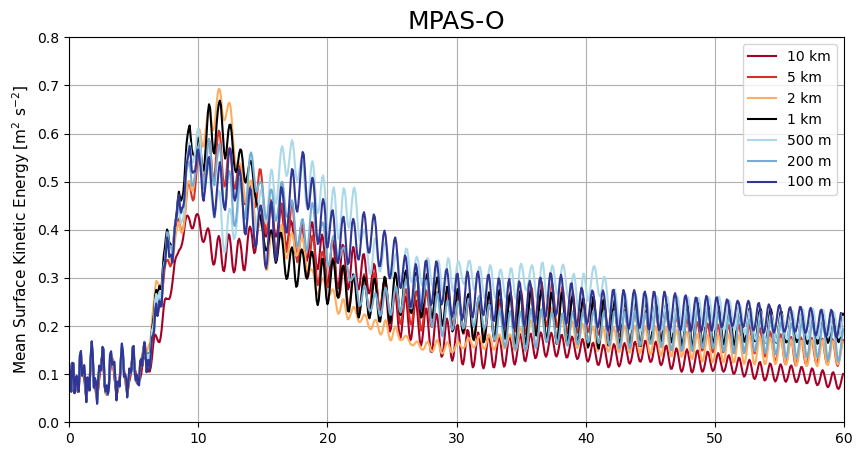

In [22]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

m_lgd = ['10 km', '5 km', '2 km', '1 km', '500 m', '200 m', '100 m']

ndays = 60
tsteps = ndays * 12

t = np.linspace(0, ndays-2/24, int(ndays/(2/24)))

for iplot in range(len(mkes)):
    # if iplot==5:
    mpas_ke = mkes[iplot]
    # elif iplot!=5:
    #     mpas_ke = mkes[iplot] / 1025
    ax.plot(t[0:len(mpas_ke)], mpas_ke[:tsteps], label=m_lgd[iplot],
           color=rainbow_cmap[iplot,:])

ax.set_ylim(0, 0.8)
ax.set_xlim(0, 60)
ax.grid(True)

ax.set_ylabel('Mean Surface Kinetic Energy [m$^{2}$ s$^{-2}$]', fontsize=11)
ax.legend(loc='upper right')
ax.set_title('MPAS-O', fontsize=18, loc='center')
# plt.text(1, 0.72, '(a)', fontsize=14)
# ax.axvspan(11, 16, color='grey', alpha=0.3, lw=0)

In [23]:
savdir = '/global/cfs/cdirs/m4304/kehinson/channel_runs/mpaso_channel/'
np.save(savdir + 'ke_10km_to_100m.npy', mkes)

In [5]:
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

In [6]:
savdir = '/global/cfs/cdirs/m4304/kehinson/channel_runs/mpaso_channel/'
mkes = np.load(savdir + 'ke_10km_to_100m.npy')

In [7]:
np.load = np_load_old

In [8]:
len(mkes)

7

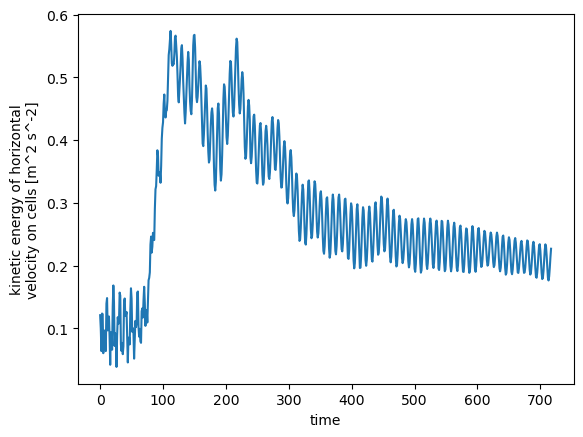

In [9]:
mkes[-1].plot()

In [10]:
m_lgd = ['10 km', '5 km', '2 km', '1 km', '500 m', '200 m', '100 m']

## Load ROMS data

### Stitch together 100 m ROMS run

In [5]:
files = [
        '/global/cfs/cdirs/m4304/kehinson/channel_runs/roms_channel/100m_qdrag/roms_his_c0.nc',
        '/global/cfs/cdirs/m4304/kehinson/channel_runs/roms_channel/100m_qdrag/roms_his_c1.nc',
        '/global/cfs/cdirs/m4304/kehinson/channel_runs/roms_channel/100m_qdrag/roms_his_c2.nc',
        '/global/cfs/cdirs/m4304/kehinson/channel_runs/roms_channel/100m_qdrag/roms_his_c3.nc',
        '/global/cfs/cdirs/m4304/kehinson/channel_runs/roms_channel/100m_qdrag/roms_his_c4.nc'
        # '/compass/ber200006/seahorce/roms_channel/bichan_GLS/200m_qdrag/roms_his.nc'
]
files

['/global/cfs/cdirs/m4304/kehinson/channel_runs/roms_channel/100m_qdrag/roms_his_c0.nc',
 '/global/cfs/cdirs/m4304/kehinson/channel_runs/roms_channel/100m_qdrag/roms_his_c1.nc',
 '/global/cfs/cdirs/m4304/kehinson/channel_runs/roms_channel/100m_qdrag/roms_his_c2.nc',
 '/global/cfs/cdirs/m4304/kehinson/channel_runs/roms_channel/100m_qdrag/roms_his_c3.nc',
 '/global/cfs/cdirs/m4304/kehinson/channel_runs/roms_channel/100m_qdrag/roms_his_c4.nc']

In [6]:
ds0 = xr.open_dataset(files[0], chunks={'ocean_time': 1})
ds1 = xr.open_dataset(files[1], chunks={'ocean_time': 1})
ds2 = xr.open_dataset(files[2], chunks={'ocean_time': 1})
ds3 = xr.open_dataset(files[3], chunks={'ocean_time': 1})
ds4 = xr.open_dataset(files[4], chunks={'ocean_time': 1})

In [7]:
ds4.ocean_time[-6]

<xarray.DataArray 'ocean_time' ()>
array(cftime.DatetimeProlepticGregorian(1, 3, 2, 0, 0, 0, 0, has_year_zero=True),
      dtype=object)
Coordinates:
    ocean_time  object 0001-03-02 00:00:00
Attributes:
    standard_name:  nulvar
    long_name:      time since initialization
    field:          time, scalar, series

In [5]:
# f0 = '/global/cfs/cdirs/m4304/kehinson/channel_runs/roms_channel/100m_qdrag/roms_his_c0.nc'

# ds = xr.open_dataset(f0, chunks={'ocean_time': 1})

In [8]:
ds0cut = ds0.isel(ocean_time=slice(0, -12))
ds1cut = ds1.isel(ocean_time=slice(0, -12))
ds2cut = ds2.isel(ocean_time=slice(0, -5))
ds3cut = ds3.isel(ocean_time=slice(0, -12))
ds4cut = ds4.isel(ocean_time=slice(0, -5))

In [9]:
ds4.ocean_time[-1]

<xarray.DataArray 'ocean_time' ()>
array(cftime.DatetimeProlepticGregorian(1, 3, 2, 10, 0, 0, 0, has_year_zero=True),
      dtype=object)
Coordinates:
    ocean_time  object 0001-03-02 10:00:00
Attributes:
    standard_name:  nulvar
    long_name:      time since initialization
    field:          time, scalar, series

In [10]:
ds4cut.ocean_time[-1]

<xarray.DataArray 'ocean_time' ()>
array(cftime.DatetimeProlepticGregorian(1, 3, 2, 0, 0, 0, 0, has_year_zero=True),
      dtype=object)
Coordinates:
    ocean_time  object 0001-03-02 00:00:00
Attributes:
    standard_name:  nulvar
    long_name:      time since initialization
    field:          time, scalar, series

In [54]:
# ds100.ocean_time.values

In [11]:
ds100 = xr.combine_by_coords([ds0cut, ds1cut, ds2cut, ds3cut, ds4cut], combine_attrs="drop_conflicts")

In [12]:
ds100['spherical'] = ds1.spherical
ds100['Vtransform']= ds1.Vtransform

In [13]:
ds, xgrid = xroms.roms_dataset(ds100)
speed = xroms.speed(ds.u, ds.v, xgrid)
KE = xroms.KE(ds.rho0, speed)
# ds['speed'] = speed
ds['ke'] = KE
ds = add_derivatives_KH(ds, xgrid)
ds = ds.isel(s_rho=-1)

In [14]:
# Calculate 100m ROMS surface KE
conditional = (ds.y_rho > 50e3) & (ds.y_rho < 250e3)
grab_ke = ds.ke.where(conditional)
r100_ke = grab_ke.mean(dim=['xi_rho', 'eta_rho']).compute()

np.save('/global/cfs/cdirs/m4304/kehinson/channel_runs/roms_channel/100m_qdrag/roms_ke_100m.npy', r100_ke)

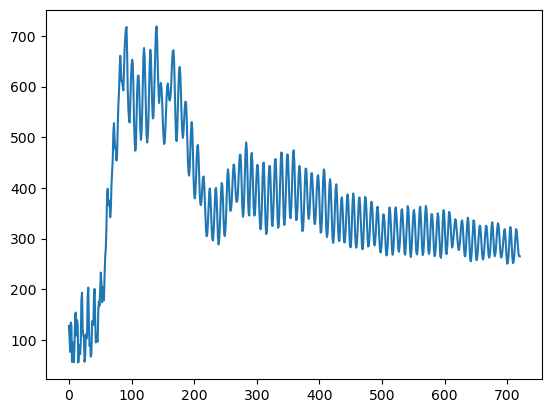

In [15]:
plt.plot(r100_ke)

In [19]:
np.save('/global/cfs/cdirs/m4304/kehinson/channel_runs/roms_channel/100m_qdrag/roms_ke_100m.npy', r100_ke)

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

ndays = 60
tsteps = ndays * 12
# t = np.linspace(0, 20-3/24, int(20/(3/24)))
# ax.plot(t, mpas_ke, '-k', label='MPAS-O')
t = np.linspace(0, ndays-2/24, int(ndays/(2/24)))
roms_grab = r100_ke / ds.rho0.values
ax.plot(t[0:len(roms_grab)], roms_grab[:tsteps], label='100 m')
# ax.plot(t, roms_grab[:tsteps], '-r', label='ROMS')

ax.grid(True)
ax.set_xlabel('Time [days]', fontsize=12)
ax.set_ylabel('Mean Surface Kinetic Energy [m$^{2}$ s$^{-2}$]', fontsize=12)
ax.legend(loc='upper right')
ax.set_title('ROMS Simulations', fontsize=18, loc='center')

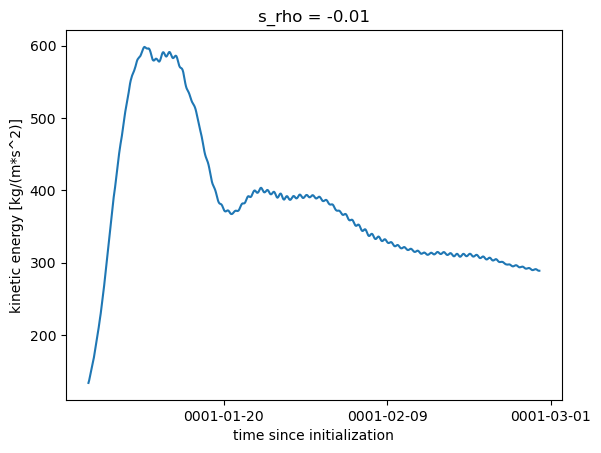

In [19]:
r100_ke.rolling(ocean_time=60, center=True).mean().plot()

In [15]:
gg = r100_ke.rolling(ocean_time=60, center=True).mean()

Text(0, 0.5, 'Size of outputs, GB')

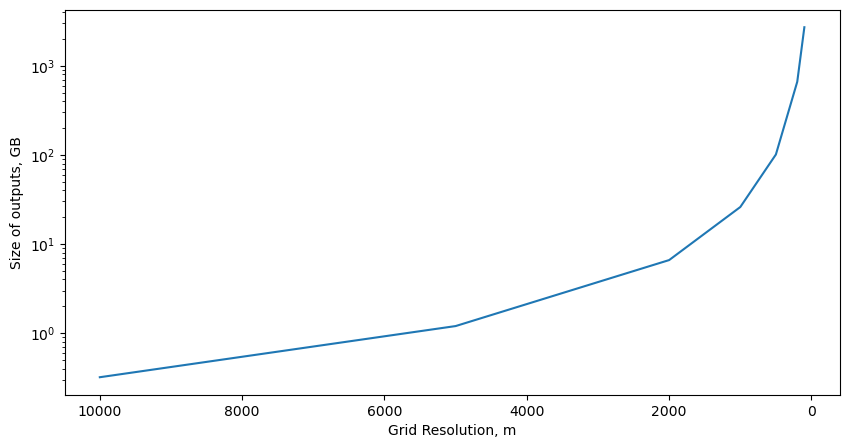

In [31]:
x = [10000, 5000, 2000, 1000, 500, 200, 100]
y = [0.32, 1.2, 6.6, 26, 101, 661, 2705]

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

ax.plot(x,y)
ax.invert_xaxis()
# plt.xscale("log")
plt.yscale("log")
ax.set_xlabel('Grid Resolution, m')
ax.set_ylabel('Size of outputs, GB')

In [65]:
roms_files = [
         # '/global/cfs/cdirs/m4304/kehinson/channel_runs/roms_channel/200m_qdrag/compass_runs/roms_his_01.nc',
         '/pscratch/sd/k/kehinson/seahorce/roms_channel/bichan_GLS/10km_qdrag/roms_his.nc',
         '/pscratch/sd/k/kehinson/seahorce/roms_channel/bichan_GLS/5km_qdrag/roms_his.nc',
         '/pscratch/sd/k/kehinson/seahorce/roms_channel/bichan_GLS/2km_qdrag/roms_his.nc',
         '/pscratch/sd/k/kehinson/seahorce/roms_channel/bichan_GLS/1km_qdrag/roms_his.nc',
         '/global/cfs/cdirs/m4304/kehinson/channel_runs/roms_channel/500m_qdrag/roms_his.nc'
        ]

roms_files

['/pscratch/sd/k/kehinson/seahorce/roms_channel/bichan_GLS/10km_qdrag/roms_his.nc',
 '/pscratch/sd/k/kehinson/seahorce/roms_channel/bichan_GLS/5km_qdrag/roms_his.nc',
 '/pscratch/sd/k/kehinson/seahorce/roms_channel/bichan_GLS/2km_qdrag/roms_his.nc',
 '/pscratch/sd/k/kehinson/seahorce/roms_channel/bichan_GLS/1km_qdrag/roms_his.nc',
 '/global/cfs/cdirs/m4304/kehinson/channel_runs/roms_channel/500m_qdrag/roms_his.nc']

In [66]:
# Load and calculate kinetic energy for ROMS datasets

dss = []
for file in roms_files:
    ds = xr.open_dataset(file, chunks={'ocean_time': 1})
    ds, xgrid = xroms.roms_dataset(ds)
    speed = xroms.speed(ds.u, ds.v, xgrid)
    KE = xroms.KE(ds.rho0, speed)
    # ds['speed'] = speed
    ds['ke'] = KE
    ds = add_derivatives_KH(ds, xgrid)
    ds = ds.isel(s_rho=-1)
    dss.append(ds)

### Calculate ROMS surface kinetic energy values for all resolutions

In [10]:
ke_roms = []

for axi in range(len(dss)):

    conditional = (dss[axi].y_rho > 50e3) & (dss[axi].y_rho < 250e3)
    grab_ke = dss[axi].ke.where(conditional)
    calc_ke = grab_ke.mean(dim=['xi_rho', 'eta_rho']).compute()

    ke_roms.append(calc_ke)

In [11]:
roms_ke_200m = np.load('/global/homes/k/kehinson/Notebooks/roms_ke_200m.npy')
roms_ke_100m = np.load('/global/cfs/cdirs/m4304/kehinson/channel_runs/roms_channel/100m_qdrag/roms_ke_100m.npy')
ke_roms.append(roms_ke_200m)
ke_roms.append(roms_ke_100m)

In [17]:
sav_dir = '/global/cfs/cdirs/m4304/kehinson/channel_runs/roms_channel/'
np.save(sav_dir + 'ke_10km_to_100m.npy', ke_roms)

In [12]:
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

In [13]:
sav_dir = '/global/cfs/cdirs/m4304/kehinson/channel_runs/roms_channel/'
ke_roms = np.load(sav_dir + 'ke_10km_to_100m.npy')

In [14]:
np.load = np_load_old

In [15]:
type(ke_roms[-2])

numpy.ndarray

In [16]:
# ke_roms[-3]

In [18]:
len(ke_roms[-2])

733

In [19]:
r200_da = xr.DataArray(
    data=ke_roms[-2][0:-12],
    dims=["ocean_time"],
    coords=dict(
        ocean_time=ke_roms[0].ocean_time.values,
    ),
    name="ke",
    attrs=dict(
        units="m^2 s^-2",
        long_name="kinetic energy",
        name="KE",
    ),
)

r100_da = xr.DataArray(
    data=ke_roms[-1],
    dims=["ocean_time"],
    coords=dict(
        ocean_time=ke_roms[0].ocean_time.values,
    ),
    name="ke",
    attrs=dict(
        units="m^2 s^-2",
        long_name="kinetic energy",
        name="KE",
    ),
)

In [20]:
ke_roms[-2] = r200_da
ke_roms[-1] = r100_da

In [15]:
mke = mkes[0]

In [17]:
# mke.rolling(Time=60, center=True).mean()

### Calculate Rolling Averages for ROMS and MPAS-O to identify 5-day windows for analyses

In [58]:
def mv_avg(x, w):
    return np.convolve(x, np.ones(w)/w, mode='same')

In [59]:
# MPAS-O moving averages

mtmax = []
mtmvals = []

for mke in range(len(mkes)-1):
    ravg = mkes[mke].rolling(Time=60, center=True).mean()
    tmax = ravg.argmax(dim=["Time"])
    tdict = [*tmax.values()][0].values
    # tmax = ravg.idxmax(dim="ocean_time").values
    mtmax.append(tdict.item())
    mtmvals.append(ravg.values[tdict.item()])


In [60]:
mtmax

[197, 140, 140, 139, 208, 141]

In [61]:
mvmp_100 = mv_avg(mkes[-1], 60)

mtmax.append(np.argmax(mvmp_100))

mtmvals.append(mvmp_100[np.argmax(mvmp_100)])

In [63]:
mtmvals

[0.3965784,
 0.52001697,
 0.57696813,
 0.5760182,
 0.5024743,
 0.5071544,
 0.5026445582509039]

In [69]:
dss[-1].rho0.values

array(1025.)

In [70]:
rho0 = 1025

In [71]:
# ROMS moving averages

rotmax = []
rotmvals = []

for ke in range(len(ke_roms)-2):
    ravg = ke_roms[ke].rolling(ocean_time=60, center=True).mean() / rho0 #dss[0].rho0.values
    tmax = ravg.argmax(dim=["ocean_time"])
    tdict = [*tmax.values()][0].values
    # tmax = ravg.idxmax(dim="ocean_time").values
    rotmax.append(tdict.item())
    rotmvals.append(ravg.values[tdict.item()])

In [72]:
mv_200 = mv_avg(ke_roms[-2], 60)
mv_100 = mv_avg(ke_roms[-1], 60) / rho0 #dss[0].rho0.values

rotmax.append(np.argmax(mv_200))
rotmax.append(np.argmax(mv_100))

rotmvals.append(mv_200[np.argmax(mv_200)])
rotmvals.append(mv_100[np.argmax(mv_100)])

In [73]:
rotmvals

[0.36155691185251587,
 0.46161648584180426,
 0.5309149167496132,
 0.5455573135819984,
 0.5922085525934203,
 0.592635358851906,
 0.5837082318230671]

In [74]:
mtmax

[197, 140, 140, 139, 208, 141, 132]

In [75]:
mtmvals

[0.3965784,
 0.52001697,
 0.57696813,
 0.5760182,
 0.5024743,
 0.5071544,
 0.5026445582509039]

In [76]:
adiv = np.array(rotmax)/12
print(adiv)
davg = adiv.tolist()
np.mean(davg)

[ 7.66666667 11.58333333  9.33333333  9.16666667 12.41666667  9.91666667
  9.33333333]


9.916666666666666

In [77]:
adiv = np.array(mtmax)/12
print(adiv)
davg = adiv.tolist()
np.mean(davg)

[16.41666667 11.66666667 11.66666667 11.58333333 17.33333333 11.75
 11.        ]


13.05952380952381

In [24]:
rotmvals

[0.36155691185251587,
 0.46161648584180426,
 0.5309149167496132,
 0.5455573135819984,
 0.5922085525934203,
 0.592635358851906,
 0.5837082318230671]

In [25]:
np.mean(rotmax)

119.0

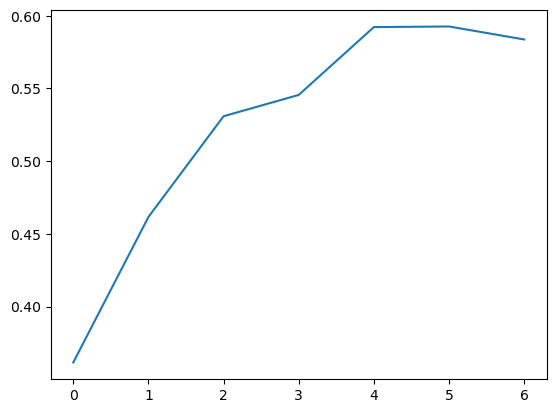

In [26]:
plt.plot(rotmvals)

In [27]:
np.mean(rotmvals)

0.5240282530420465

In [31]:
bb = np.convolve(ke_roms[-3], np.ones(60)/60, mode='same')
bb[150]

605.9993353580429

In [85]:
cc = [*tmax.values()][0].values
cc

array(149)

In [88]:
cc.item()

149

In [59]:
tmax

{'ocean_time': <xarray.DataArray 'ke' ()>
 array(149)
 Coordinates:
     s_rho    float64 -0.01
 Attributes:
     long_name:  kinetic energy
     units:      kg/(m*s^2)
     name:       KE}

In [21]:
roms_lgd = ['10 km', '5 km', '2 km', '1 km', '500 m', '200 m', '100 m']

In [22]:
rainbow_cmap = np.asarray([[165,0,38],
                         [215,48,39],
                         [253,174,97],
                         [0,0,0],
                         [171,217,233],
                         [116,173,209],
                         [49,54,149]]) / 255

rainbow_cmap

array([[0.64705882, 0.        , 0.14901961],
       [0.84313725, 0.18823529, 0.15294118],
       [0.99215686, 0.68235294, 0.38039216],
       [0.        , 0.        , 0.        ],
       [0.67058824, 0.85098039, 0.91372549],
       [0.45490196, 0.67843137, 0.81960784],
       [0.19215686, 0.21176471, 0.58431373]])

In [32]:
dss[0].rho0.values

array(1025.)

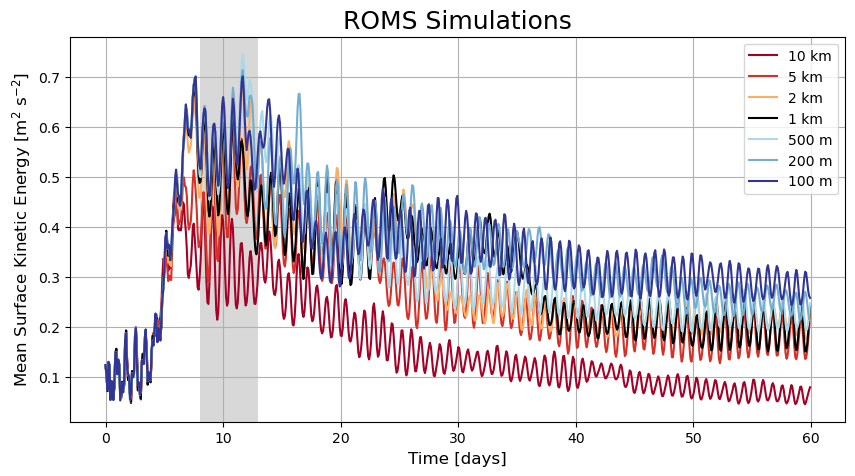

In [80]:
### Quadratic Drag

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

ndays = 60
tsteps = ndays * 12
# t = np.linspace(0, 20-3/24, int(20/(3/24)))
# ax.plot(t, mpas_ke, '-k', label='MPAS-O')
t = np.linspace(0, ndays-2/24, int(ndays/(2/24)))
for iplot in range(len(ke_roms)):
    if iplot != 5:
        roms_grab = ke_roms[iplot] / 1025 #dss[0].rho0.values
    elif iplot == 5:
        roms_grab = ke_roms[iplot]
    ax.plot(t[0:len(roms_grab)], roms_grab[:tsteps],
            label=roms_lgd[iplot], color=rainbow_cmap[iplot,:])
# ax.plot(t, roms_grab[:tsteps], '-r', label='ROMS')
ax.grid(True)
ax.set_xlabel('Time [days]', fontsize=12)
ax.set_ylabel('Mean Surface Kinetic Energy [m$^{2}$ s$^{-2}$]', fontsize=12)
ax.legend(loc='upper right')
ax.set_title('ROMS Simulations', fontsize=18, loc='center')
ax.axvspan(8, 13, color='grey', alpha=0.3, lw=0)

## Plot combined ROMS and MPAS plots

In [21]:
rainbow_cmap = np.asarray([[165,0,38],
                         [215,48,39],
                         [253,174,97],
                         [0,0,0],
                         [171,217,233],
                         [116,173,209],
                         [49,54,149]]) / 255

rainbow_cmap

array([[0.64705882, 0.        , 0.14901961],
       [0.84313725, 0.18823529, 0.15294118],
       [0.99215686, 0.68235294, 0.38039216],
       [0.        , 0.        , 0.        ],
       [0.67058824, 0.85098039, 0.91372549],
       [0.45490196, 0.67843137, 0.81960784],
       [0.19215686, 0.21176471, 0.58431373]])

In [22]:
res_lgd = ['10 km', '5 km', '2 km', '1 km', '500 m', '200 m', '100 m']

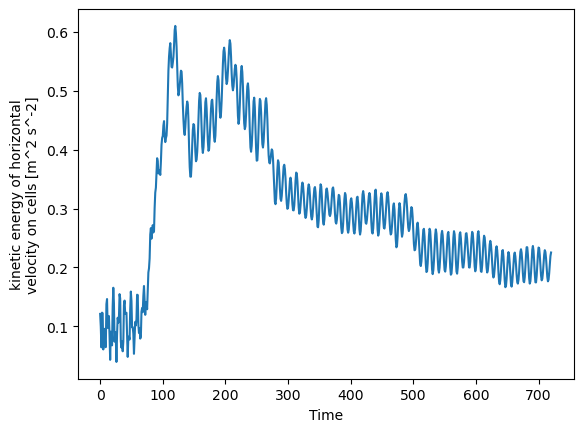

In [23]:
mkes[-3].plot()

Text(0.5, 1.0, 'MPAS-O')

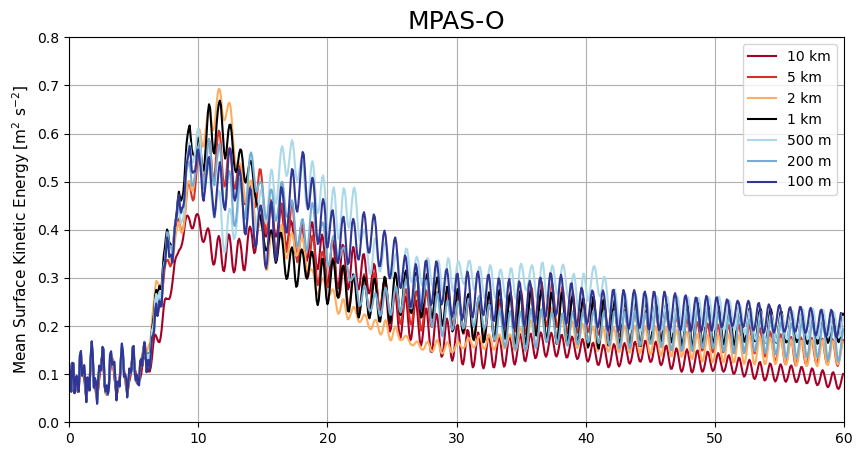

In [24]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

ndays = 60
tsteps = ndays * 12

t = np.linspace(0, ndays-2/24, int(ndays/(2/24)))

for iplot in range(len(mkes)):
    if iplot==5:
        mpas_ke = mkes[iplot]
    elif iplot!=5:
        mpas_ke = mkes[iplot] #/ 1025
    ax.plot(t[0:len(mpas_ke)], mpas_ke[:tsteps], label=res_lgd[iplot],
           color=rainbow_cmap[iplot,:])

ax.set_ylim(0, 0.8)
ax.set_xlim(0, 60)
ax.grid(True)

ax.set_ylabel('Mean Surface Kinetic Energy [m$^{2}$ s$^{-2}$]', fontsize=11)
ax.legend(loc='upper right')
ax.set_title('MPAS-O', fontsize=18, loc='center')
# plt.text(1, 0.72, '(a)', fontsize=14)
# ax.axvspan(11, 16, color='grey', alpha=0.3, lw=0)

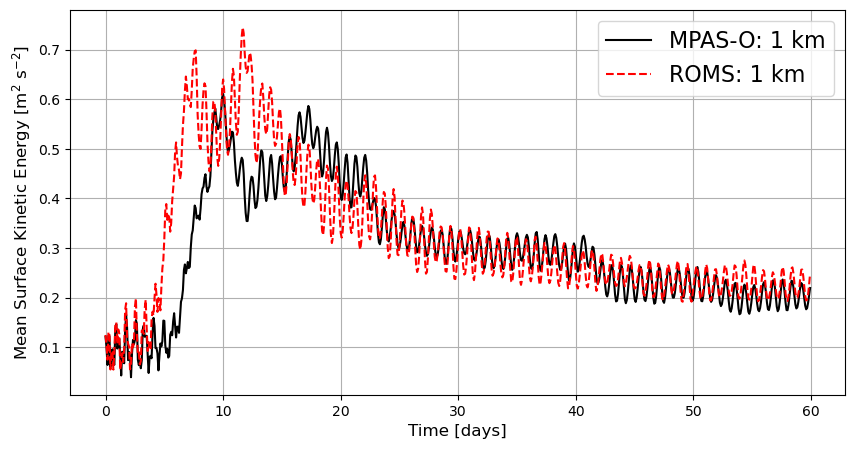

In [25]:
# MPAS vs ROMS at 1 km resolution
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

ndays = 60
tsteps = ndays * 12

t = np.linspace(0, ndays-2/24, int(ndays/(2/24)))

mpas_ke = mkes[4]
roms_grab = ke_roms[4] / 1025 #dss[0].rho0.values

ax.plot(t[0:len(mpas_ke)], mpas_ke[:tsteps],
        label='MPAS-O: 1 km', color='k')
ax.plot(t[0:len(roms_grab)], roms_grab[:tsteps],
        label='ROMS: 1 km', color='r', linestyle='--')
# ax.plot(t, roms_grab[:tsteps], '-r', label='ROMS')
ax.grid(True)
ax.set_xlabel('Time [days]', fontsize=12)
ax.set_ylabel('Mean Surface Kinetic Energy [m$^{2}$ s$^{-2}$]', fontsize=12)
ax.legend(loc='upper right', fontsize=16)


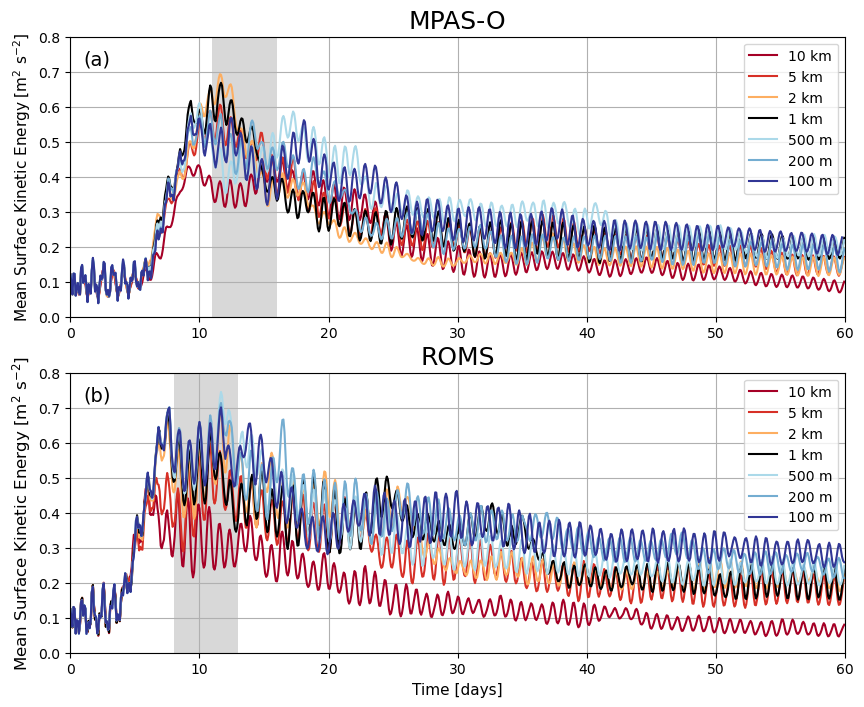

In [26]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(211)

ndays = 60
tsteps = ndays * 12
# t = np.linspace(0, 20-3/24, int(20/(3/24)))
# ax.plot(t, mpas_ke, '-k', label='MPAS-O')
t = np.linspace(0, ndays-2/24, int(ndays/(2/24)))
icolor = 0
for iplot in range(len(mkes)):
    mpas_ke = mkes[iplot]
    ax.plot(t[0:len(mpas_ke)], mpas_ke[:tsteps], label=res_lgd[iplot],
           color=rainbow_cmap[icolor,:])
    icolor+=1
# ax.plot(t, roms_ke[:tsteps], '-r', label='ROMS')
ax.set_ylim(0, 0.8)
ax.set_xlim(0, 60)
ax.grid(True)
# ax.set_xlabel('Time [days]', fontsize=12)
ax.set_ylabel('Mean Surface Kinetic Energy [m$^{2}$ s$^{-2}$]', fontsize=11)
ax.legend(loc='upper right')
ax.set_title('MPAS-O', fontsize=18, loc='center')
plt.text(1, 0.72, '(a)', fontsize=14)
ax.axvspan(11, 16, color='grey', alpha=0.3, lw=0)

ax = fig.add_subplot(212)

ndays = 60
tsteps = ndays * 12
# t = np.linspace(0, 20-3/24, int(20/(3/24)))
# ax.plot(t, mpas_ke, '-k', label='MPAS-O')
t = np.linspace(0, ndays-2/24, int(ndays/(2/24)))
icolor = 0
for iplot in range(len(ke_roms)):
    if iplot==len(ke_roms)-2:
        roms_ke = ke_roms[iplot]
    else:
        roms_ke = ke_roms[iplot] / dss[0].rho0.values
    ax.plot(t[0:len(roms_ke)], roms_ke[:tsteps], label=res_lgd[iplot],
           color=rainbow_cmap[icolor,:])
    icolor+=1
# ax.plot(t, roms_ke[:tsteps], '-r', label='ROMS')
ax.set_ylim(0, 0.8)
ax.set_xlim(0, 60)
ax.grid(True)
ax.set_xlabel('Time [days]', fontsize=11)
ax.set_ylabel('Mean Surface Kinetic Energy [m$^{2}$ s$^{-2}$]', fontsize=12)
ax.legend(loc='upper right')
ax.set_title('ROMS', fontsize=18, loc='center')
plt.text(1, 0.72, '(b)', fontsize=14)
ax.axvspan(8, 13, color='grey', alpha=0.3, lw=0)

savepath = '/global/u2/k/kehinson/Notebooks/Channel_Paper/Figures/'
# fig.savefig(savepath + 'Figure4_KEtimeseries.png', format='png', dpi=300)

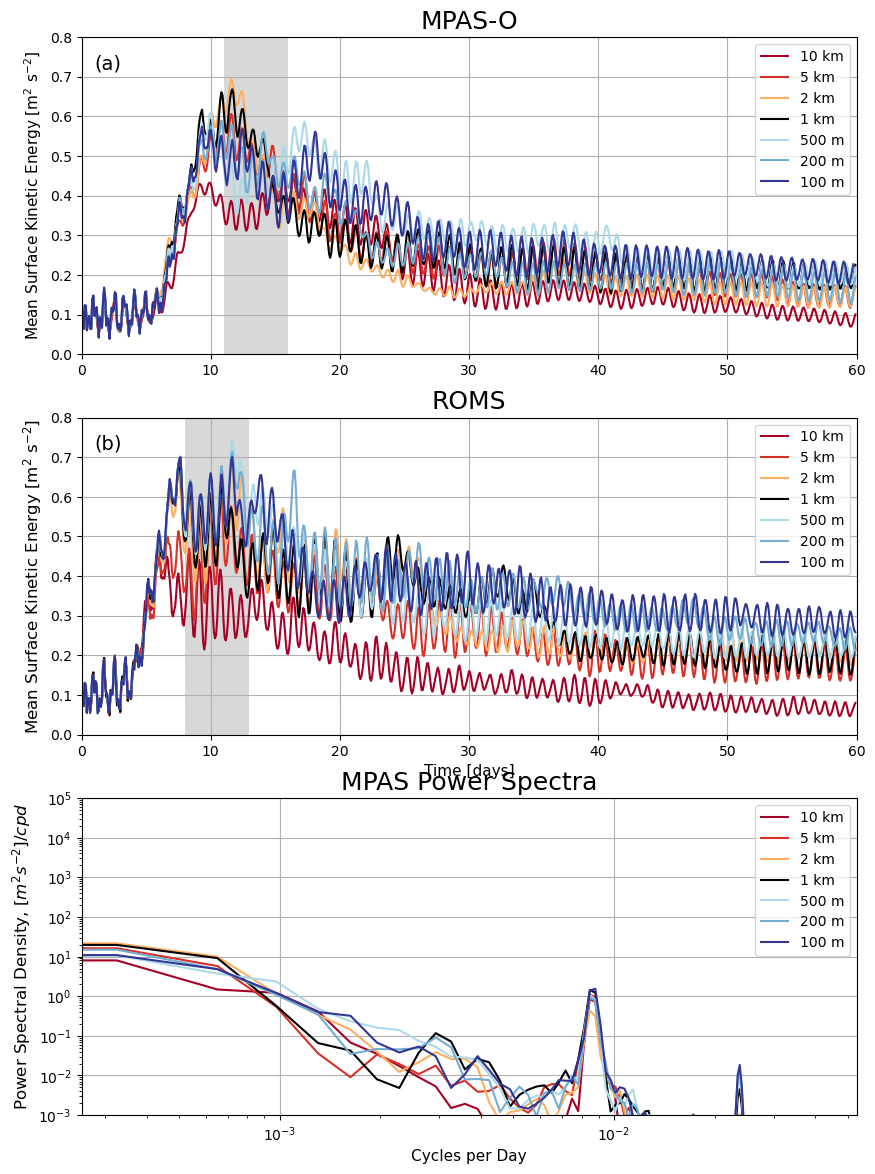

In [31]:
fig = plt.figure(figsize=(10, 14))
ax = fig.add_subplot(311)

ndays = 60
tsteps = ndays * 12
# t = np.linspace(0, 20-3/24, int(20/(3/24)))
# ax.plot(t, mpas_ke, '-k', label='MPAS-O')
t = np.linspace(0, ndays-2/24, int(ndays/(2/24)))
icolor = 0
for iplot in range(len(mkes)):
    mpas_ke = mkes[iplot]
    ax.plot(t[0:len(mpas_ke)], mpas_ke[:tsteps], label=res_lgd[iplot],
           color=rainbow_cmap[icolor,:])
    icolor+=1
# ax.plot(t, roms_ke[:tsteps], '-r', label='ROMS')
ax.set_ylim(0, 0.8)
ax.set_xlim(0, 60)
ax.grid(True)
# ax.set_xlabel('Time [days]', fontsize=12)
ax.set_ylabel('Mean Surface Kinetic Energy [m$^{2}$ s$^{-2}$]', fontsize=11)
ax.legend(loc='upper right')
ax.set_title('MPAS-O', fontsize=18, loc='center')
plt.text(1, 0.72, '(a)', fontsize=14)
ax.axvspan(11, 16, color='grey', alpha=0.3, lw=0)

ax = fig.add_subplot(312)

ndays = 60
tsteps = ndays * 12
# t = np.linspace(0, 20-3/24, int(20/(3/24)))
# ax.plot(t, mpas_ke, '-k', label='MPAS-O')
t = np.linspace(0, ndays-2/24, int(ndays/(2/24)))
icolor = 0
for iplot in range(len(ke_roms)):
    if iplot==len(ke_roms)-2:
        roms_ke = ke_roms[iplot]
    else:
        roms_ke = ke_roms[iplot] / 1025 #dss[0].rho0.values
    ax.plot(t[0:len(roms_ke)], roms_ke[:tsteps], label=res_lgd[iplot],
           color=rainbow_cmap[icolor,:])
    icolor+=1
# ax.plot(t, roms_ke[:tsteps], '-r', label='ROMS')
ax.set_ylim(0, 0.8)
ax.set_xlim(0, 60)
ax.grid(True)
ax.set_xlabel('Time [days]', fontsize=11)
ax.set_ylabel('Mean Surface Kinetic Energy [m$^{2}$ s$^{-2}$]', fontsize=12)
ax.legend(loc='upper right')
ax.set_title('ROMS', fontsize=18, loc='center')
plt.text(1, 0.72, '(b)', fontsize=14)
ax.axvspan(8, 13, color='grey', alpha=0.3, lw=0)

ax = fig.add_subplot(313)
icolor = 0
for i in range(len(mpas_fs)):
    ax.loglog(mpas_fs[i], mpas_pden[i], label=res_lgd[i], color=rainbow_cmap[icolor,:])
    icolor+=1
    
ax.set_ylim([1e-3, 1E5])
ax.set_xlabel('Cycles per Day', fontsize=11)
ax.set_ylabel(r'Power Spectral Density, $[m^2 s^{-2}]/cpd$', fontsize=12)
ax.set_title('MPAS Power Spectra', fontsize=18, loc='center')
ax.legend()
ax.grid()

savepath = '/global/u2/k/kehinson/Notebooks/Channel_Paper/Figures/'
# fig.savefig(savepath + 'Figure4_KEtimeseries.png', format='png', dpi=300)

## Decompose time series into periodogram?

In [38]:
# plt.psd(mkes[0])
# plt.psd(mkes[1])
# plt.psd(mkes[2])
# plt.psd(mkes[3])
# plt.psd(mkes[4])
# plt.psd(mkes[5])
# plt.psd(mkes[6])

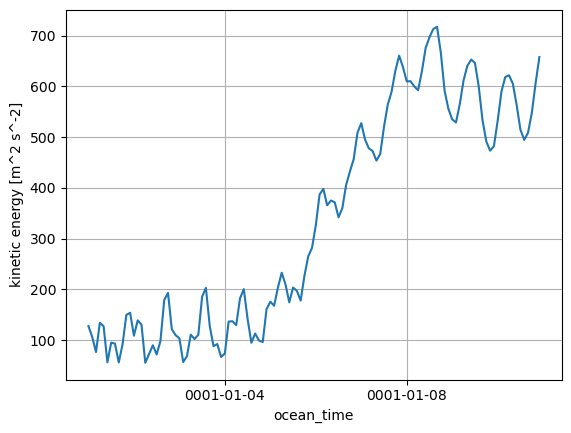

In [40]:
ke_roms[-1][0:120].plot()
plt.grid()

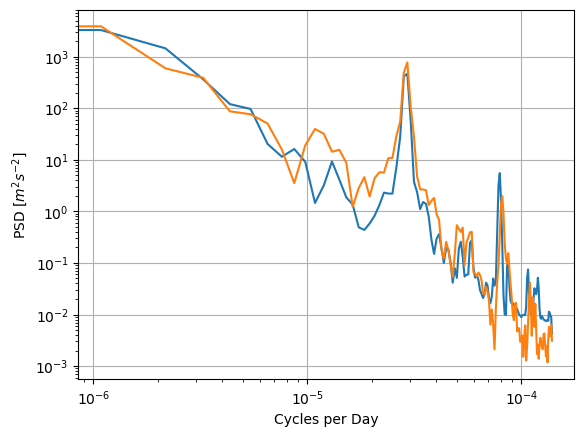

In [41]:
f, Pxx_den = signal.welch(mkes[-1], 1/3600)
plt.loglog(f, Pxx_den)
f2, Pxx_den2 = signal.welch(ke_roms[-1]/1025, 1/3600)
plt.loglog(f2, Pxx_den2)
# plt.ylim([0.5e-3, 1])
plt.xlabel('Cycles per Day')
plt.ylabel(r'PSD $[m^2 s^{-2}]$')
plt.grid()
plt.show()

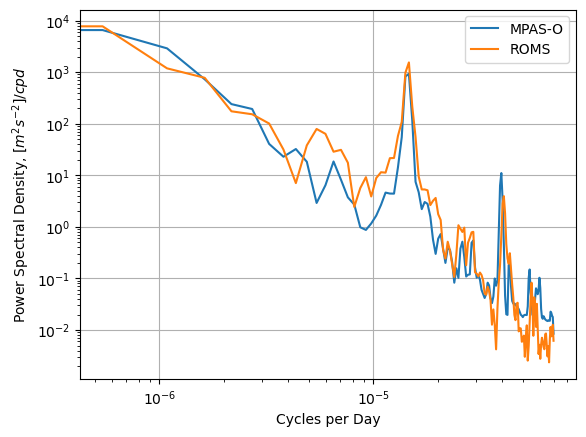

In [47]:
f, Pxx_den = signal.welch(mkes[-1], 1/7200)
plt.loglog(f, Pxx_den, label='MPAS-O')
f2, Pxx_den2 = signal.welch(ke_roms[-1]/1025, 1/7200)
plt.loglog(f2, Pxx_den2, label='ROMS')
# plt.ylim([0.5e-3, 1])
plt.xlabel('Cycles per Day')
plt.ylabel(r'Power Spectral Density, $[m^2 s^{-2}]/cpd$')
plt.legend()
plt.grid()
plt.show()

In [29]:
roms_fs = []
roms_pden = []

div_factor = 12

ictr = 0
for rgrab in ke_roms:
    if ictr==5:
        # f, Pxx_den = signal.periodogram(rgrab, 1/7200)
        f, Pxx_den = signal.welch(rgrab, 1/div_factor)
    else:
        # f, Pxx_den = signal.periodogram(rgrab/1025, 1/7200)
        f, Pxx_den = signal.welch(rgrab/1025, 1/div_factor)
    roms_fs.append(f)
    roms_pden.append(Pxx_den)
    ictr+=1

In [26]:
mpas_fs = []
mpas_pden = []

div_factor = 12

ictr = 0
for mgrab in mkes:
    # f, Pxx_den = signal.periodogram(rgrab, 1/7200)
    f, Pxx_den = signal.welch(mgrab, 1/div_factor)
    mpas_fs.append(f)
    mpas_pden.append(Pxx_den)
    ictr+=1

In [27]:
res_lgd

['10 km', '5 km', '2 km', '1 km', '500 m', '200 m', '100 m']

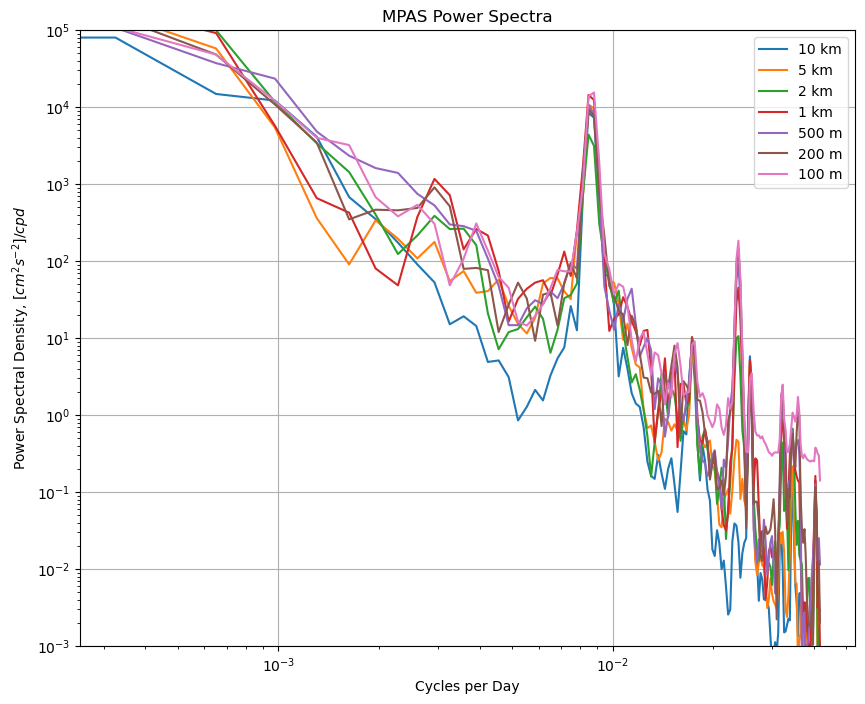

In [28]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

for i in range(len(mpas_fs)):
    ax.loglog(mpas_fs[i], mpas_pden[i]*(100**2), label=res_lgd[i])
    
ax.set_ylim([1e-3, 1E5])
ax.set_xlabel('Cycles per Day')
ax.set_ylabel(r'Power Spectral Density, $[cm^2 s^{-2}]/cpd$')
ax.set_title('MPAS Power Spectra')
ax.legend()
ax.grid()

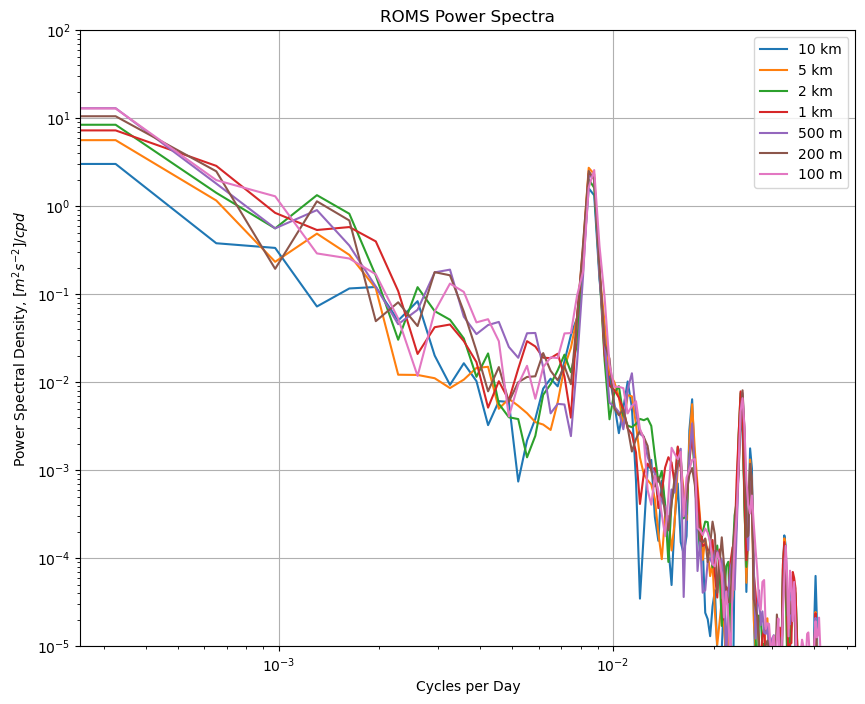

In [30]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

for i in range(len(roms_fs)):
    ax.loglog(roms_fs[i], roms_pden[i], label=res_lgd[i])
    
ax.set_ylim([1e-5, 1E2])
ax.set_xlabel('Cycles per Day')
ax.set_ylabel(r'Power Spectral Density, $[m^2 s^{-2}]/cpd$')
ax.set_title('ROMS Power Spectra')
ax.legend()
ax.grid()

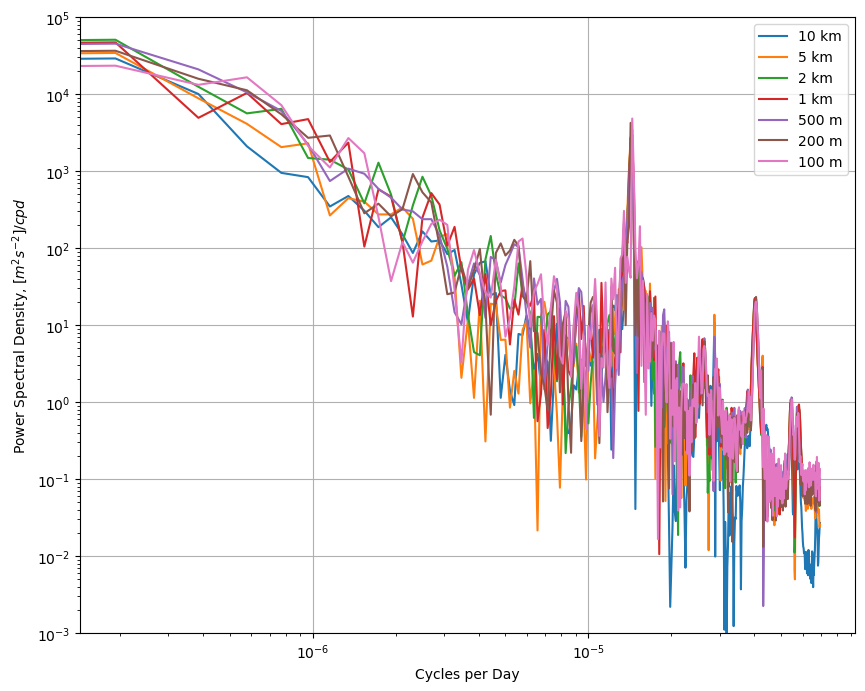

In [70]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

for i in range(len(roms_fs)):
    ax.loglog(roms_fs[i], roms_pden[i], label=res_lgd[i])
    
ax.set_ylim([1e-3, 1E5])
ax.set_xlabel('Cycles per Day')
ax.set_ylabel(r'Power Spectral Density, $[m^2 s^{-2}]/cpd$')
ax.legend()
ax.grid()

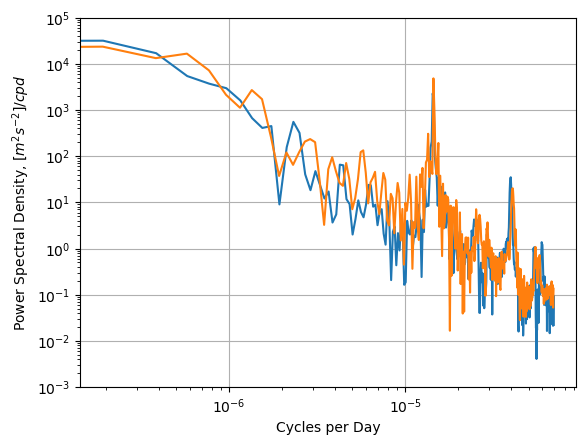

In [61]:
f, Pxx_den = signal.periodogram(mkes[-1], 1/7200)
f2, Pxx_den2 = signal.periodogram(ke_roms[-1]/1025, 1/7200)

plt.loglog(f, Pxx_den)
plt.loglog(f2, Pxx_den2)

# plt.ylim([1e-7, 1e2])
# plt.xlabel('frequency [Hz]')
# plt.ylabel('PSD [V**2/Hz]')
plt.ylim([1e-3, 1E5])
plt.xlabel('Cycles per Day')
plt.ylabel(r'Power Spectral Density, $[m^2 s^{-2}]/cpd$')

plt.grid()
plt.show()

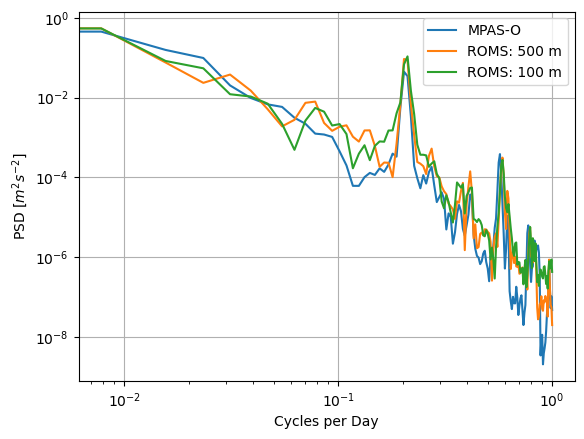

In [42]:
f, Pxx_den = signal.welch(mkes[-3], 2)
plt.loglog(f, Pxx_den, label='MPAS-O')
f2, Pxx_den2 = signal.welch(ke_roms[-3]/1025, 2)
f3, Pxx_den3 = signal.welch(ke_roms[-1]/1025, 2)
plt.loglog(f2, Pxx_den2, label='ROMS: 500 m')
plt.loglog(f3, Pxx_den3, label='ROMS: 100 m')
# plt.ylim([0.5e-3, 1])
plt.xlabel('Cycles per Day')
plt.ylabel(r'PSD $[m^2 s^{-2}]$')
plt.grid()
plt.legend(loc='best')
plt.show()

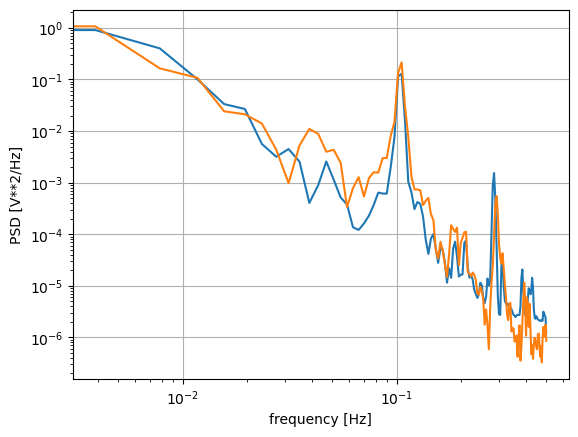

In [26]:
f, Pxx_den = signal.welch(mkes[-1])
plt.loglog(f, Pxx_den)
f2, Pxx_den2 = signal.welch(ke_roms[-1]/1025)
plt.loglog(f2, Pxx_den2)
# plt.ylim([0.5e-3, 1])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.grid()
plt.show()

In [104]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

In [129]:
np.pi/50

0.06283185307179587

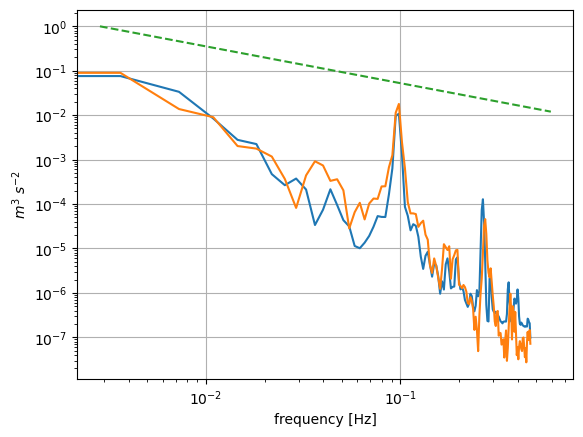

In [128]:
f, Pxx_den = signal.welch(mkes[-1], 12)
plt.loglog(f/12.9, Pxx_den)
f2, Pxx_den2 = signal.welch(ke_roms[-1]/rho0, 12)
plt.loglog(f2/12.9, Pxx_den2)
# plt.ylim([0.5e-3, 1])
plt.grid()
plt.xlabel('frequency [Hz]')
plt.ylabel('$m^3$ $s^{-2}$')
# plt.ylim([1E-9, 1E0])
abline(-5/3, 1)
plt.show()


In [ ]:
len(mpas_ke)

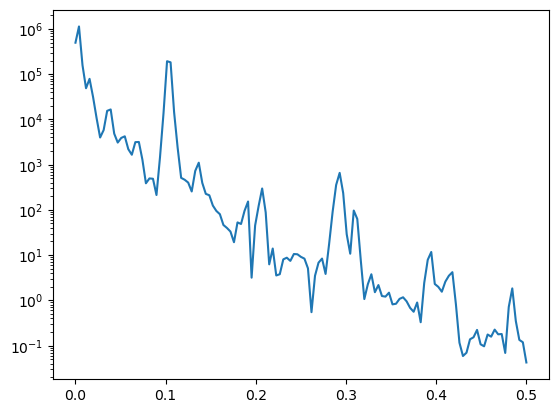

In [54]:
from scipy import signal
f, Pxx_den = signal.welch(mpas_ke)
plt.semilogy(f, Pxx_den)

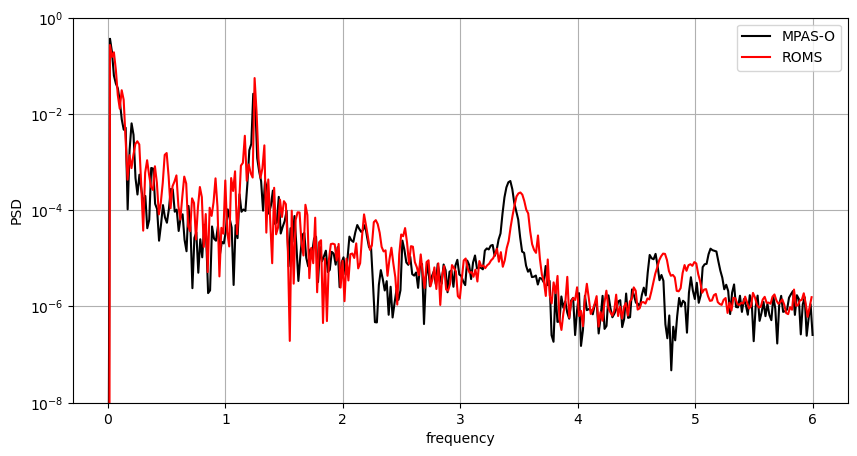

In [90]:
from scipy import signal

mpas_ke = mkes[-1]
roms_ke = ke_roms[-1] / dss[0].rho0.values

fs = 12 # sampling frequency, corresponds to 1 day
f_mpas, mpas_Pxx_den = signal.periodogram(mpas_ke, 12)
f_roms, roms_Pxx_den = signal.periodogram(roms_ke, 12)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

plt.semilogy(f_mpas, mpas_Pxx_den, '-k', label='MPAS-O')
plt.semilogy(f_roms, roms_Pxx_den, '-r', label='ROMS')
plt.ylim([1e-8, 1e0])
plt.xlabel('frequency')
plt.ylabel('PSD')
plt.legend()
plt.grid()
plt.show()

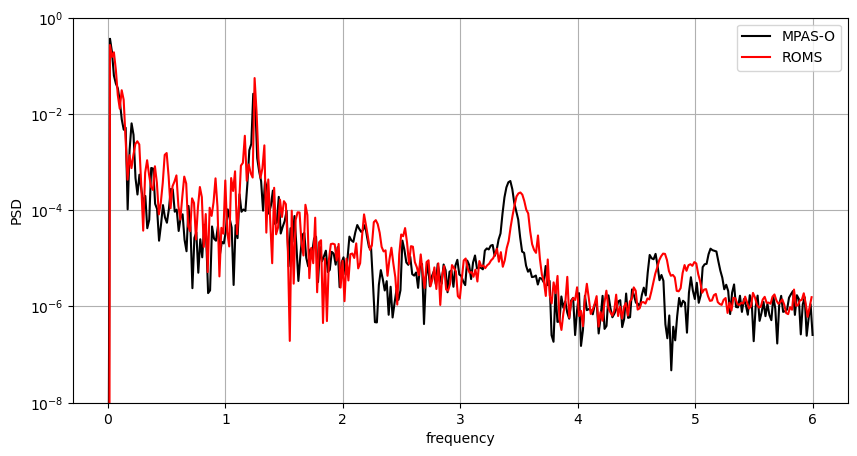

In [25]:
from scipy import signal

mpas_ke = mkes[-1]
roms_ke = ke_roms[-1] / dss[0].rho0.values

fs = 12 # sampling frequency, corresponds to 1 day
f_mpas, mpas_Pxx_den = signal.periodogram(mpas_ke, 12)
f_roms, roms_Pxx_den = signal.periodogram(roms_ke, 12)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

plt.semilogy(f_mpas, mpas_Pxx_den, '-k', label='MPAS-O')
plt.semilogy(f_roms, roms_Pxx_den, '-r', label='ROMS')
plt.ylim([1e-8, 1e0])
plt.xlabel('frequency')
plt.ylabel('PSD')
plt.legend()
plt.grid()
plt.show()

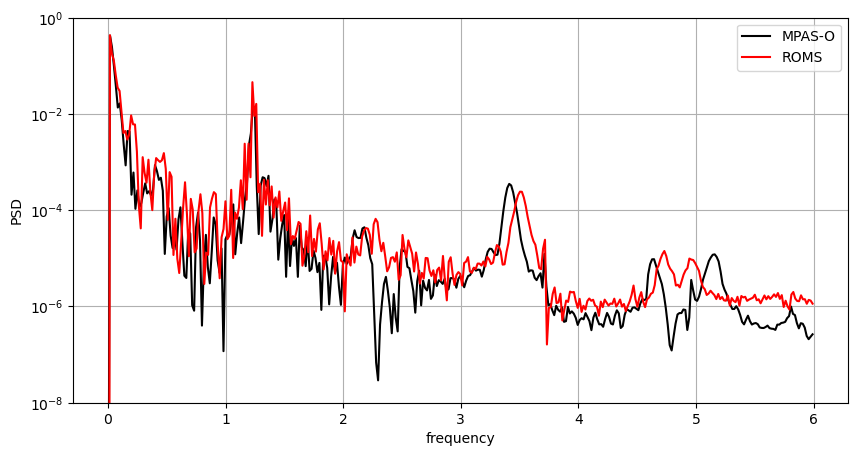

In [26]:
from scipy import signal

mpas_ke = mkes[-2]
roms_ke = ke_roms[-2]# / dss[0].rho0.values

fs = 12 # sampling frequency, corresponds to 1 day
f_mpas, mpas_Pxx_den = signal.periodogram(mpas_ke, 12)
f_roms, roms_Pxx_den = signal.periodogram(roms_ke, 12)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

plt.semilogy(f_mpas, mpas_Pxx_den, '-k', label='MPAS-O')
plt.semilogy(f_roms, roms_Pxx_den, '-r', label='ROMS')
plt.ylim([1e-8, 1e0])
plt.xlabel('frequency')
plt.ylabel('PSD')
plt.legend()
plt.grid()
plt.show()

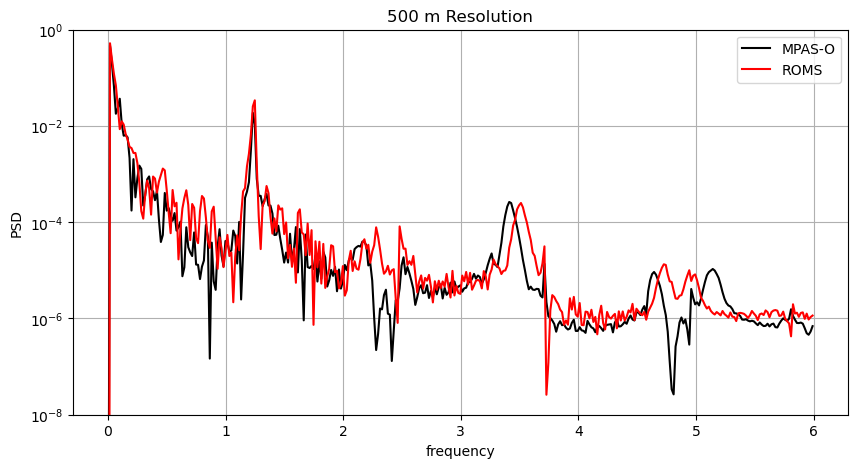

In [39]:
from scipy import signal

mpas_ke = mkes[4]
roms_ke = ke_roms[4] / dss[0].rho0.values

fs = 12 # sampling frequency, corresponds to 1 day
f_mpas, mpas_Pxx_den = signal.periodogram(mpas_ke, 12)
f_roms, roms_Pxx_den = signal.periodogram(roms_ke, 12)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

plt.semilogy(f_mpas, mpas_Pxx_den, '-k', label='MPAS-O')
plt.semilogy(f_roms, roms_Pxx_den, '-r', label='ROMS')
plt.ylim([1e-8, 1e0])
plt.xlabel('frequency')
plt.ylabel('PSD')
plt.title('500 m Resolution')
plt.legend()
plt.grid()
plt.show()